<a href="https://colab.research.google.com/github/Ashish542004/NeuroLens/blob/main/final_image_classifier_neurolens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tarfile
from torchvision.datasets.utils import download_url

def ensure_cifar10_dataset():
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
    data_dir = './data/cifar10'
    archive_path = './cifar10.tgz'
    if not os.path.exists(data_dir):
        print("Downloading CIFAR-10 dataset...")
        download_url(dataset_url, '.')
        print("Extracting CIFAR-10 dataset...")
        with tarfile.open(archive_path, 'r:gz') as tar:
            tar.extractall(path='./data')
        print("CIFAR-10 dataset ready!")
    else:
        print("Dataset already exists.")

ensure_cifar10_dataset()


Dataset already exists.


In [ ]:
!pip install -q torchvision

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.ImageFolder(root='./data/cifar10/train', transform=transform_train)
testset = torchvision.datasets.ImageFolder(root='./data/cifar10/test', transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
import torchvision.models as models

class CIFAR10ResNet(nn.Module):
    def __init__(self):
        super(CIFAR10ResNet, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10ResNet().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


In [ ]:
from tqdm import tqdm
def train(epoch):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch}")):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch} | Loss: {running_loss/len(trainloader):.3f} | Acc: {100.*correct/total:.2f}%")


def test():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc


In [ ]:
save_path = '/content/drive/MyDrive/cifar10_models'
os.makedirs(save_path, exist_ok=True)

best_acc = 0

for epoch in range(1, 31):  # Try increasing to 100 for better results
    train(epoch)
    acc = test()
    scheduler.step()
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), os.path.join(save_path, 'best_cifar10_model.pth'))

print(f"Best Accuracy: {best_acc:.2f}%")


Epoch 1: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s]

Epoch 1 | Loss: 1.173 | Acc: 57.67%


Test Accuracy: 65.31%


Epoch 2: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch 2 | Loss: 0.825 | Acc: 71.10%


Test Accuracy: 73.18%


Epoch 3: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]

Epoch 3 | Loss: 0.653 | Acc: 77.24%


Test Accuracy: 75.35%


Epoch 4: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch 4 | Loss: 0.552 | Acc: 80.80%


Test Accuracy: 77.29%


Epoch 5: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]

Epoch 5 | Loss: 0.485 | Acc: 83.30%


Test Accuracy: 83.92%


Epoch 6: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch 6 | Loss: 0.427 | Acc: 85.24%


Test Accuracy: 82.43%


Epoch 7: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]

Epoch 7 | Loss: 0.393 | Acc: 86.30%


Test Accuracy: 82.54%


Epoch 8: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch 8 | Loss: 0.352 | Acc: 87.78%


Test Accuracy: 85.72%


Epoch 9: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s]

Epoch 9 | Loss: 0.324 | Acc: 88.76%


Test Accuracy: 84.86%


Epoch 10: 100%|██████████| 391/391 [00:45<00:00,  8.58it/s]

Epoch 10 | Loss: 0.302 | Acc: 89.53%


Test Accuracy: 88.16%


Epoch 11: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]

Epoch 11 | Loss: 0.277 | Acc: 90.28%


Test Accuracy: 88.07%


Epoch 12: 100%|██████████| 391/391 [00:45<00:00,  8.63it/s]

Epoch 12 | Loss: 0.254 | Acc: 91.18%


Test Accuracy: 87.01%


Epoch 13: 100%|██████████| 391/391 [00:45<00:00,  8.63it/s]

Epoch 13 | Loss: 0.235 | Acc: 91.91%


Test Accuracy: 88.71%


Epoch 14: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Epoch 14 | Loss: 0.219 | Acc: 92.23%


Test Accuracy: 88.83%


Epoch 15: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s]

Epoch 15 | Loss: 0.200 | Acc: 93.05%


Test Accuracy: 87.24%


Epoch 16: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]

Epoch 16 | Loss: 0.185 | Acc: 93.51%


Test Accuracy: 87.87%


Epoch 17: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]

Epoch 17 | Loss: 0.174 | Acc: 94.07%


Test Accuracy: 89.22%


Epoch 18: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]

Epoch 18 | Loss: 0.157 | Acc: 94.64%


Test Accuracy: 88.76%


Epoch 19: 100%|██████████| 391/391 [00:45<00:00,  8.63it/s]

Epoch 19 | Loss: 0.152 | Acc: 94.70%


Test Accuracy: 90.66%


Epoch 20: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]

Epoch 20 | Loss: 0.138 | Acc: 95.12%


Test Accuracy: 90.05%


Epoch 21: 100%|██████████| 391/391 [00:45<00:00,  8.58it/s]

Epoch 21 | Loss: 0.130 | Acc: 95.35%


Test Accuracy: 89.83%


Epoch 22: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch 22 | Loss: 0.117 | Acc: 95.79%


Test Accuracy: 89.19%


Epoch 23: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Epoch 23 | Loss: 0.113 | Acc: 95.99%


Test Accuracy: 90.34%


Epoch 24: 100%|██████████| 391/391 [00:45<00:00,  8.60it/s]

Epoch 24 | Loss: 0.102 | Acc: 96.38%


Test Accuracy: 89.95%


Epoch 25: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]

Epoch 25 | Loss: 0.100 | Acc: 96.43%


Test Accuracy: 90.68%


Epoch 26: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]

Epoch 26 | Loss: 0.090 | Acc: 96.78%


Test Accuracy: 90.30%


Epoch 27: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch 27 | Loss: 0.085 | Acc: 97.04%


Test Accuracy: 91.40%


Epoch 28: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]

Epoch 28 | Loss: 0.074 | Acc: 97.36%


Test Accuracy: 90.82%


Epoch 29: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]

Epoch 29 | Loss: 0.074 | Acc: 97.37%


Test Accuracy: 91.38%


Epoch 30: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]

Epoch 30 | Loss: 0.067 | Acc: 97.64%


Test Accuracy: 90.37%
Best Accuracy: 91.40%


In [ ]:
# Define the model architecture again (must match the saved model)
model = CIFAR10ResNet().to(device)

# Load the saved state_dict from Google Drive
checkpoint_path = '/content/drive/MyDrive/cifar10_models/best_cifar10_model.pth'
model.load_state_dict(torch.load(checkpoint_path))

# Set model to evaluation mode
model.eval()

print("✅ Best model loaded successfully!")


✅ Best model loaded successfully!


In [ ]:
# Re-define optimizer with lower learning rate for fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Use cosine scheduler again if needed
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [ ]:
import torch.nn.functional as F

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        logprobs = F.log_softmax(pred, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        return (confidence * nll_loss + self.smoothing * smooth_loss).mean()

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)


In [ ]:
fine_tune_epochs = 15  # You can increase if loss is still improving
for epoch in range(1, fine_tune_epochs + 1):
    train(epoch)
    acc = test()
    scheduler.step()

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), os.path.join(save_path, 'best_cifar10_model.pth'))
        print("✅ New best model saved!")

print(f"🔥 Fine-tuned Best Accuracy: {best_acc:.2f}%")


Epoch 1: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch 1 | Loss: 1.081 | Acc: 96.62%


Test Accuracy: 90.69%


Epoch 2: 100%|██████████| 391/391 [00:45<00:00,  8.68it/s]

Epoch 2 | Loss: 0.698 | Acc: 97.92%


Test Accuracy: 91.95%
✅ New best model saved!


Epoch 3: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch 3 | Loss: 0.656 | Acc: 98.59%


Test Accuracy: 92.43%
✅ New best model saved!


Epoch 4: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch 4 | Loss: 0.636 | Acc: 98.77%


Test Accuracy: 92.57%
✅ New best model saved!


Epoch 5: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch 5 | Loss: 0.623 | Acc: 98.94%


Test Accuracy: 92.77%
✅ New best model saved!


Epoch 6: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch 6 | Loss: 0.615 | Acc: 99.05%


Test Accuracy: 92.78%
✅ New best model saved!


Epoch 7: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]

Epoch 7 | Loss: 0.608 | Acc: 99.05%


Test Accuracy: 92.92%
✅ New best model saved!


Epoch 8: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]

Epoch 8 | Loss: 0.604 | Acc: 99.19%


Test Accuracy: 92.88%


Epoch 9: 100%|██████████| 391/391 [00:45<00:00,  8.67it/s]

Epoch 9 | Loss: 0.603 | Acc: 99.21%


Test Accuracy: 92.93%
✅ New best model saved!


Epoch 10: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch 10 | Loss: 0.603 | Acc: 99.09%


Test Accuracy: 92.98%
✅ New best model saved!


Epoch 11: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Epoch 11 | Loss: 0.602 | Acc: 99.20%


Test Accuracy: 92.95%


Epoch 12: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch 12 | Loss: 0.602 | Acc: 99.22%


Test Accuracy: 92.90%


Epoch 13: 100%|██████████| 391/391 [00:45<00:00,  8.69it/s]

Epoch 13 | Loss: 0.601 | Acc: 99.20%


Test Accuracy: 92.89%


Epoch 14: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s]

Epoch 14 | Loss: 0.600 | Acc: 99.19%


Test Accuracy: 92.90%


Epoch 15: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]

Epoch 15 | Loss: 0.596 | Acc: 99.20%


Test Accuracy: 92.94%
🔥 Fine-tuned Best Accuracy: 92.98%


In [ ]:
# Define the model architecture again
model = CIFAR10ResNet().to(device)

# Load the best model weights from Google Drive
checkpoint_path = '/content/drive/MyDrive/cifar10_models/best_cifar10_model.pth'
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

print("✅ Model loaded and ready for testing!")


✅ Model loaded and ready for testing!


In [ ]:
def test():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    print(f"📊 Final Test Accuracy: {acc:.2f}%")
    return acc

# Run the test
test()


📊 Final Test Accuracy: 92.98%


92.98

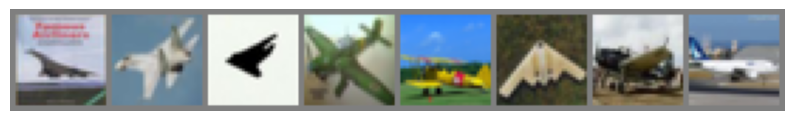

GroundTruth:  airplane airplane airplane airplane airplane airplane airplane airplane
Predicted  :  airplane airplane airplane airplane airplane airplane airplane airplane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show images and predictions
imshow(torchvision.utils.make_grid(images[:8]))
print("GroundTruth: ", ' '.join(f'{classes[labels[j]]}' for j in range(8)))
print("Predicted  : ", ' '.join(f'{classes[predicted[j]]}' for j in range(8)))


Actual Label   : airplane
Predicted Label: airplane


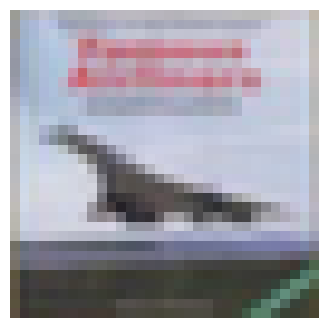

In [ ]:
def predict_single_image(image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return classes[predicted.item()]

# Example:
img, label = testset[0]
print("Actual Label   :", classes[label])
print("Predicted Label:", predict_single_image(img))
imshow(img)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dog.jpg to dog.jpg


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# CIFAR-10 normalization stats
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# Define the same test-time transform
transform_real = transforms.Compose([
    transforms.Resize((32, 32)),        # Resize to match CIFAR-10
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load and preprocess uploaded image
import io
filename = next(iter(uploaded))  # Get the uploaded file name
image = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
image_tensor = transform_real(image).unsqueeze(0).to(device)  # Add batch dimension


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


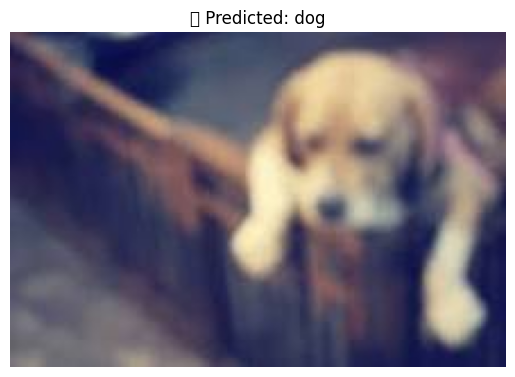

In [ ]:
# Run the model on the real image
model.eval()
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = classes[predicted.item()]

# Display the uploaded image
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(f"🧠 Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [ ]:
import numpy as np

# Initialize counters
class_correct = np.zeros(len(classes))
class_total = np.zeros(len(classes))

model.eval()
with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = predicted.eq(targets)

        for i in range(len(targets)):
            label = targets[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print class-wise accuracy
print("📊 Class-wise Test Accuracy:\n")
for i in range(len(classes)):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"{classes[i]:<10}: {acc:.2f}%")


📊 Class-wise Test Accuracy:

airplane  : 94.30%
automobile: 97.30%
bird      : 89.80%
cat       : 85.40%
deer      : 94.80%
dog       : 88.90%
frog      : 94.00%
horse     : 94.30%
ship      : 95.50%
truck     : 95.50%
